# Code and References/Resources:

Paper: Mattei, P.A. and Frellsen, J., 2019, May. MIWAE: Deep generative modelling and imputation of incomplete data sets. In International Conference on Machine Learning (pp. 4413-4423). PMLR.

Important Reference Paper: Burda, Y., Grosse, R. and Salakhutdinov, R., 2015. Importance weighted autoencoders. arXiv preprint arXiv:1509.00519.

Code:
1) https://github.com/pamattei/miwae/blob/master/Pytorch%20notebooks/MIWAE_Pytorch_exercises_demo_ProbAI.ipynb : Use a t-Distribution in MIWAE

2) For IWAE: https://github.com/xqding/Importance_Weighted_Autoencoders :Excellent implementation of IWAE 

3) https://github.com/adithyaiyer1999/IWAE-MNIST: Adithya Iyer(Presenter’s) previous work on IWAE


Honor Code

# We pledge that all the work in this Project are ours and ours only, and any references we used have been thoroughly cited.

Adithya Iyer, 16D110011 and Abhishek Tandon, 16D110014

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Building a MIWAE, Reading Model and Data

In [2]:
transforms = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(
        './data',
        train=True,
        download=True,
        transform=transforms)

test_dataset = datasets.MNIST(
        './data',
        train=False,
        download=True,
        transform=transforms
    )

train_data_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=1000)

# Removing data from train set
def removeProbData(tensorOG, p):
    image =tensorOG.numpy()
    nump = np.random.rand(image.shape[0],image.shape[1])
    mask = (nump<(1-p))*1.0
    img_removed = mask*image
    
    return torch.from_numpy(mask), torch.from_numpy(img_removed)

# Building the encoder separately
class BasicBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BasicBlock, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.transform = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                       nn.Tanh(),
                                       nn.Linear(hidden_dim, hidden_dim),
                                       nn.Tanh())
        self.fc_mu = nn.Linear(hidden_dim, output_dim)
        self.fc_logsigma = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out = self.transform(x)
        mu = self.fc_mu(out)
        logsigma = self.fc_logsigma(out)
        sigma = torch.exp(logsigma)
        return mu, sigma
    
# Model
class MIWAE(nn.Module):
    def __init__(self, dim_h1, dim_image_vars):
        super(MIWAE, self).__init__()
        self.dim_h1 = dim_h1
        self.dim_image_vars = dim_image_vars

        ## encoder
        self.encoder_h1 = BasicBlock(dim_image_vars, 200, dim_h1)
        
        ## decoder
        self.decoder_x =  nn.Sequential(nn.Linear(dim_h1, 200),
                                        nn.Tanh(),
                                        nn.Linear(200, 200),
                                        nn.Tanh(),
                                        nn.Linear(200, dim_image_vars),
                                        nn.Sigmoid())
        
    def encoder(self, x):
        mu_h1, sigma_h1 = self.encoder_h1(x)
        eps = Variable(sigma_h1.data.new(sigma_h1.size()).normal_())
        h1 = mu_h1 + sigma_h1 * eps   
        return h1, mu_h1, sigma_h1, eps
    
    def decoder(self, h1):
        p = self.decoder_x(h1)

        return p
    
    def forward(self, x):
        h1, mu_h1, sigma_h1, eps = self.encoder(x)
        p = self.decoder(h1)
        return (h1, mu_h1, sigma_h1, eps), (p)

    def train_loss(self, inputs):
        h1, mu_h1, sigma_h1, eps = self.encoder(inputs)
        #log_Qh1Gx = torch.sum(-0.5*((h1-mu_h1)/sigma_h1)**2 - torch.log(sigma_h1), -1)
        log_Qh1Gx = torch.sum(-0.5*(eps)**2 - torch.log(sigma_h1), -1)
        
        p = self.decoder(h1)
        log_Ph1 = torch.sum(-0.5*h1**2, -1)
        log_PxGh1 = torch.sum(inputs*torch.log(p) + (1-inputs)*torch.log(1-p), -1)

        log_weight = log_Ph1 + log_PxGh1 - log_Qh1Gx
        log_weight = log_weight - torch.max(log_weight, 0)[0]
        weight = torch.exp(log_weight)
        weight = weight / torch.sum(weight, 0)
        weight = Variable(weight.data, requires_grad = False)
        loss = -torch.mean(torch.sum(weight * (log_Ph1 + log_PxGh1 - log_Qh1Gx), 0))

        return loss

    
    def impute(self, inputs):
        inputs1 = inputs
        h1, mu_h1, sigma_h1, eps = self.encoder(inputs1)
        #log_Qh1Gx = torch.sum(-0.5*((h1-mu_h1)/sigma_h1)**2 - torch.log(sigma_h1), -1)
        log_Qh1Gx = torch.sum(-0.5*(eps)**2 - torch.log(sigma_h1), -1)
        
        p = self.decoder(h1)
        #print(p.shape)
        log_Ph1 = torch.sum(-0.5*h1**2, -1)
        log_PxGh1 = torch.sum(inputs1*torch.log(p) + (1-inputs1)*torch.log(1-p), -1)

        log_weight = log_Ph1 + log_PxGh1 - log_Qh1Gx
        log_weight = log_weight - torch.max(log_weight, 0)[0]
        
        weight = torch.exp(log_weight)
        weight = weight / torch.sum(weight, 0)
        #print(weight.shape)
        #weight = Variable(weight.data, requires_grad = False)
        weight.unsqueeze_(-1)
        weight = weight.expand(5,784)
        #print(weight.shape)
        img = torch.mean(weight * (p), 0)

        return img
    
vae = MIWAE(50, 784)
vae.double()

vae.load_state_dict(torch.load("miwae.pt"))
vae.eval()


100.1%

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


113.5%

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


100.4%

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


180.4%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


MIWAE(
  (encoder_h1): BasicBlock(
    (transform): Sequential(
      (0): Linear(in_features=784, out_features=200, bias=True)
      (1): Tanh()
      (2): Linear(in_features=200, out_features=200, bias=True)
      (3): Tanh()
    )
    (fc_mu): Linear(in_features=200, out_features=50, bias=True)
    (fc_logsigma): Linear(in_features=200, out_features=50, bias=True)
  )
  (decoder_x): Sequential(
    (0): Linear(in_features=50, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

# Reading Some Test data

In [3]:
# Reading some of the test data
for epoch in range(1):
    running_loss = [] 
    for idx, data in enumerate(test_data_loader):
        inputs = Variable(data[0])
        inputs = inputs.view(-1, 28 * 28)
        inputs = inputs.expand(5, 1000, 784)
        
# Removing Pixels while testing
def removeProbDataTest(tensorOG, p):
    image =tensorOG.numpy()
    nump = np.random.rand(image.shape[0])
    mask = (nump<(1-p))*1.0
    img_removed = mask*image
    
    return torch.from_numpy((mask==0)*1), torch.from_numpy(img_removed)

# Using MIWAE To Impute

Original Image | Pixels Missing values | Imputed Image NO:  1


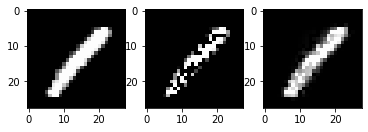

Original Image | Pixels Missing values | Imputed Image NO:  2


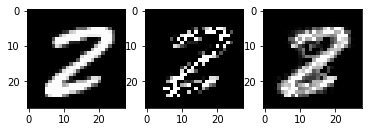

Original Image | Pixels Missing values | Imputed Image NO:  3


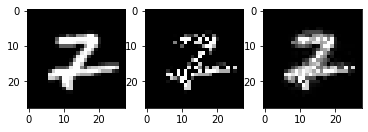

Original Image | Pixels Missing values | Imputed Image NO:  4


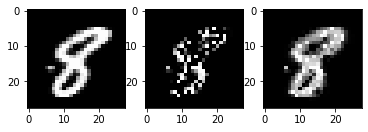

Original Image | Pixels Missing values | Imputed Image NO:  5


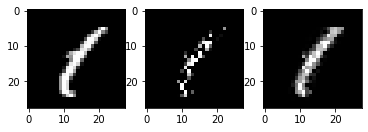

Original Image | Pixels Missing values | Imputed Image NO:  6


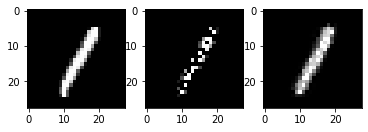

Original Image | Pixels Missing values | Imputed Image NO:  7


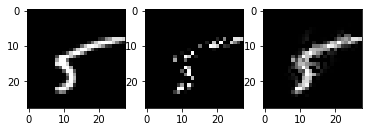

Original Image | Pixels Missing values | Imputed Image NO:  8


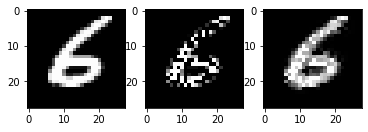

Original Image | Pixels Missing values | Imputed Image NO:  9


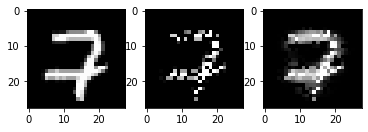

Original Image | Pixels Missing values | Imputed Image NO:  10


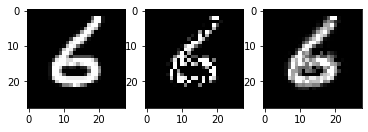

Original Image | Pixels Missing values | Imputed Image NO:  11


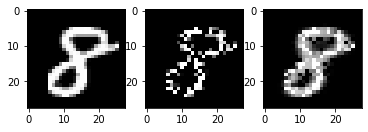

Original Image | Pixels Missing values | Imputed Image NO:  12


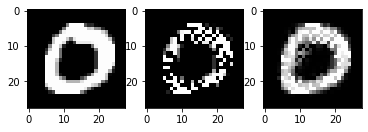

Original Image | Pixels Missing values | Imputed Image NO:  13


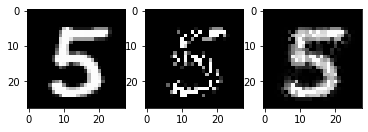

Original Image | Pixels Missing values | Imputed Image NO:  14


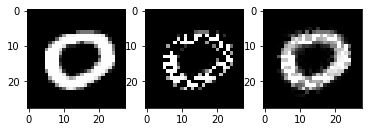

Original Image | Pixels Missing values | Imputed Image NO:  15


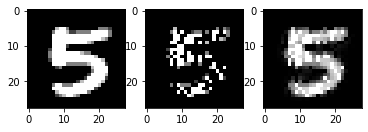

Original Image | Pixels Missing values | Imputed Image NO:  16


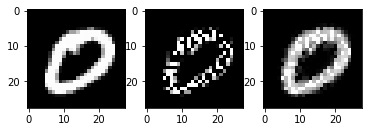

Original Image | Pixels Missing values | Imputed Image NO:  17


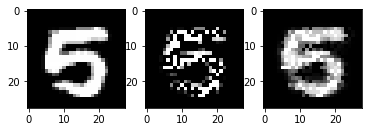

Original Image | Pixels Missing values | Imputed Image NO:  18


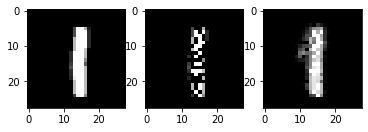

Original Image | Pixels Missing values | Imputed Image NO:  19


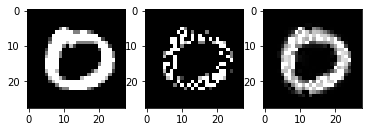

Original Image | Pixels Missing values | Imputed Image NO:  20


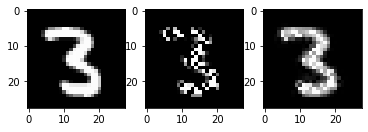

Original Image | Pixels Missing values | Imputed Image NO:  21


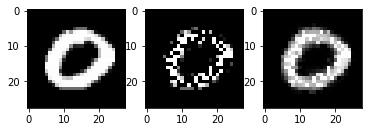

Original Image | Pixels Missing values | Imputed Image NO:  22


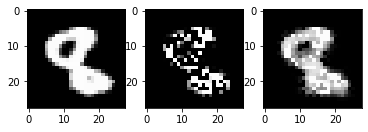

Original Image | Pixels Missing values | Imputed Image NO:  23


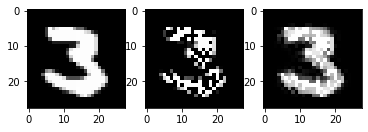

Original Image | Pixels Missing values | Imputed Image NO:  24


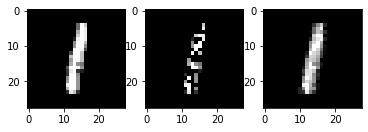

Original Image | Pixels Missing values | Imputed Image NO:  25


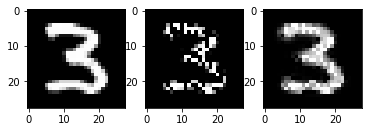

Original Image | Pixels Missing values | Imputed Image NO:  26


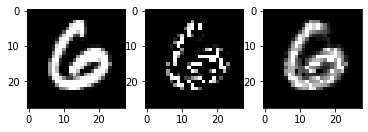

Original Image | Pixels Missing values | Imputed Image NO:  27


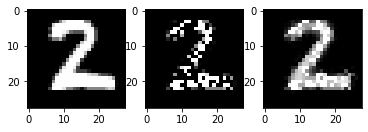

Original Image | Pixels Missing values | Imputed Image NO:  28


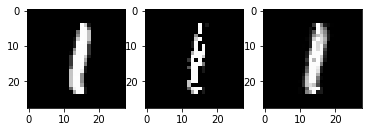

Original Image | Pixels Missing values | Imputed Image NO:  29


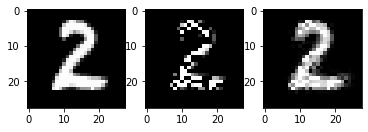

Original Image | Pixels Missing values | Imputed Image NO:  30


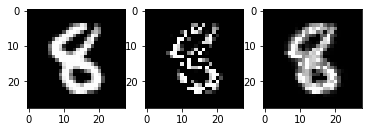

Original Image | Pixels Missing values | Imputed Image NO:  31


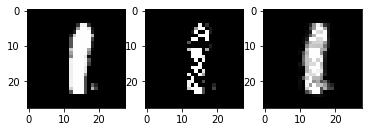

Original Image | Pixels Missing values | Imputed Image NO:  32


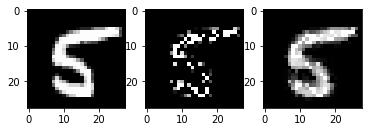

Original Image | Pixels Missing values | Imputed Image NO:  33


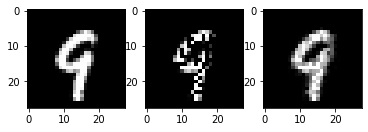

Original Image | Pixels Missing values | Imputed Image NO:  34


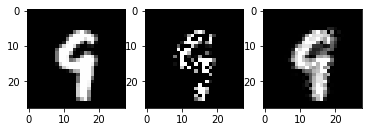

Original Image | Pixels Missing values | Imputed Image NO:  35


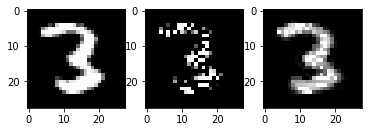

Original Image | Pixels Missing values | Imputed Image NO:  36


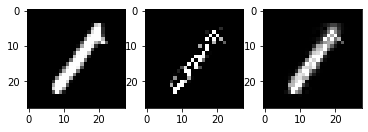

Original Image | Pixels Missing values | Imputed Image NO:  37


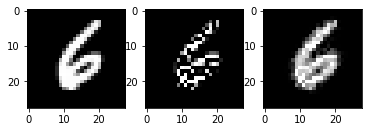

Original Image | Pixels Missing values | Imputed Image NO:  38


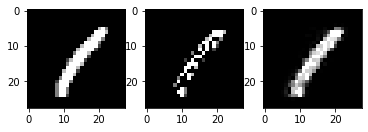

Original Image | Pixels Missing values | Imputed Image NO:  39


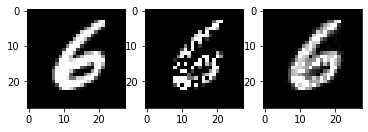

Original Image | Pixels Missing values | Imputed Image NO:  40


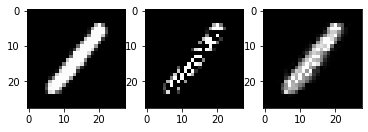

Original Image | Pixels Missing values | Imputed Image NO:  41


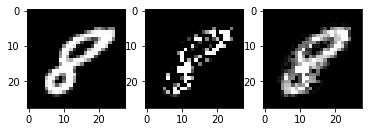

Original Image | Pixels Missing values | Imputed Image NO:  42


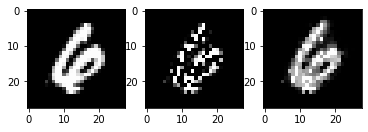

Original Image | Pixels Missing values | Imputed Image NO:  43


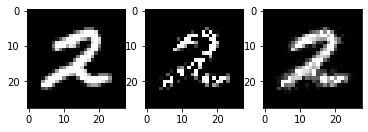

Original Image | Pixels Missing values | Imputed Image NO:  44


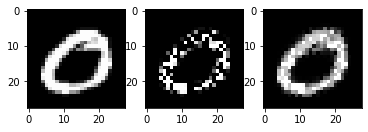

Original Image | Pixels Missing values | Imputed Image NO:  45


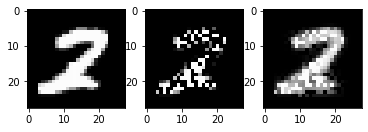

Original Image | Pixels Missing values | Imputed Image NO:  46


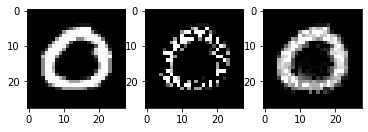

Original Image | Pixels Missing values | Imputed Image NO:  47


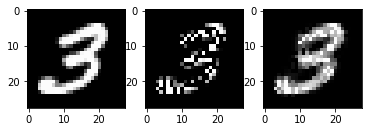

Original Image | Pixels Missing values | Imputed Image NO:  48


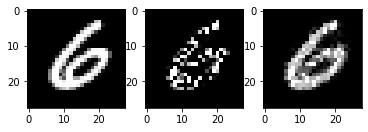

Original Image | Pixels Missing values | Imputed Image NO:  49


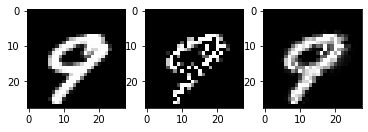

Original Image | Pixels Missing values | Imputed Image NO:  50


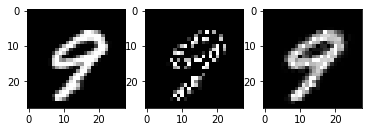

Original Image | Pixels Missing values | Imputed Image NO:  51


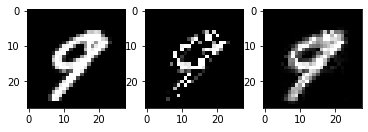

Original Image | Pixels Missing values | Imputed Image NO:  52


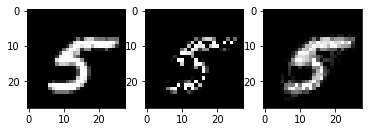

Original Image | Pixels Missing values | Imputed Image NO:  53


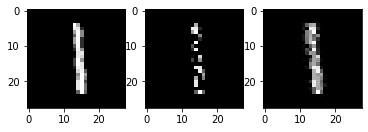

Original Image | Pixels Missing values | Imputed Image NO:  54


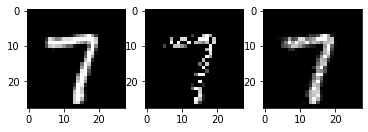

Original Image | Pixels Missing values | Imputed Image NO:  55


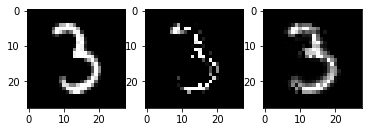

Original Image | Pixels Missing values | Imputed Image NO:  56


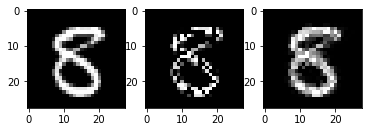

Original Image | Pixels Missing values | Imputed Image NO:  57


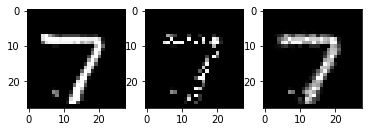

Original Image | Pixels Missing values | Imputed Image NO:  58


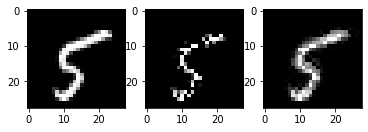

Original Image | Pixels Missing values | Imputed Image NO:  59


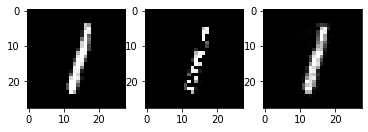

Original Image | Pixels Missing values | Imputed Image NO:  60


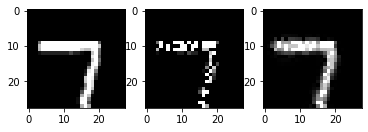

Original Image | Pixels Missing values | Imputed Image NO:  61


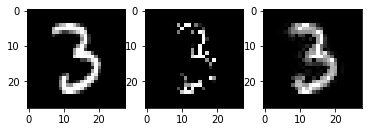

Original Image | Pixels Missing values | Imputed Image NO:  62


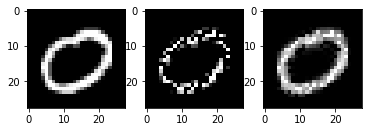

Original Image | Pixels Missing values | Imputed Image NO:  63


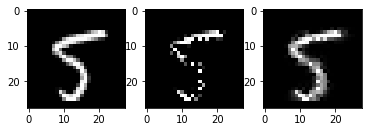

Original Image | Pixels Missing values | Imputed Image NO:  64


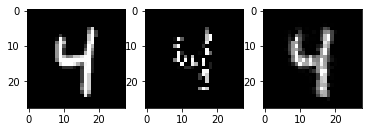

Original Image | Pixels Missing values | Imputed Image NO:  65


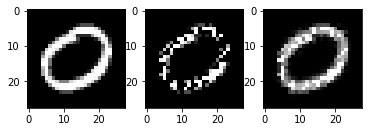

Original Image | Pixels Missing values | Imputed Image NO:  66


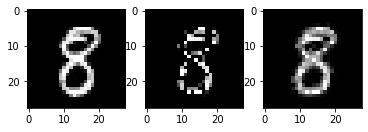

Original Image | Pixels Missing values | Imputed Image NO:  67


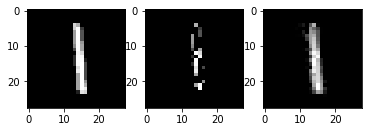

Original Image | Pixels Missing values | Imputed Image NO:  68


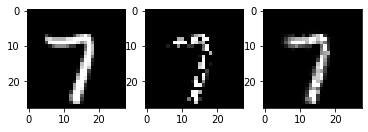

Original Image | Pixels Missing values | Imputed Image NO:  69


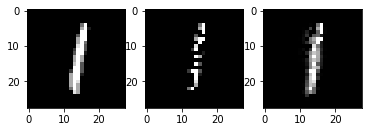

Original Image | Pixels Missing values | Imputed Image NO:  70


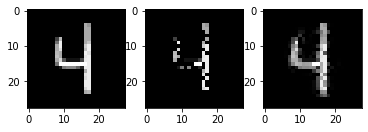

Original Image | Pixels Missing values | Imputed Image NO:  71


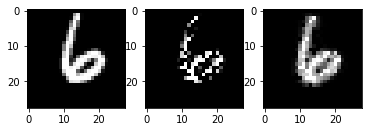

Original Image | Pixels Missing values | Imputed Image NO:  72


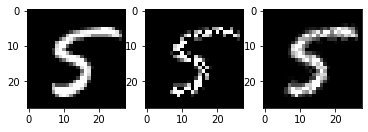

Original Image | Pixels Missing values | Imputed Image NO:  73


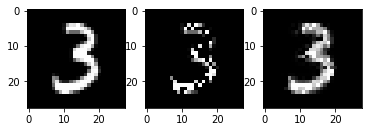

Original Image | Pixels Missing values | Imputed Image NO:  74


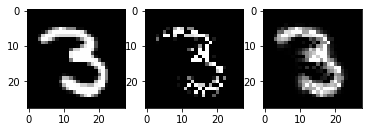

Original Image | Pixels Missing values | Imputed Image NO:  75


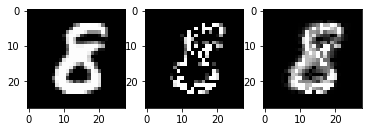

Original Image | Pixels Missing values | Imputed Image NO:  76


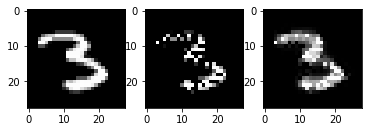

Original Image | Pixels Missing values | Imputed Image NO:  77


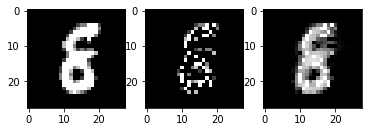

Original Image | Pixels Missing values | Imputed Image NO:  78


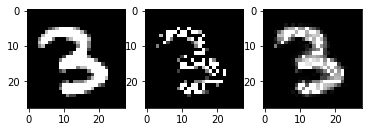

Original Image | Pixels Missing values | Imputed Image NO:  79


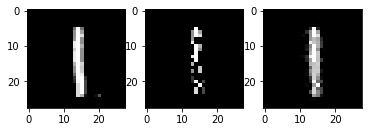

Original Image | Pixels Missing values | Imputed Image NO:  80


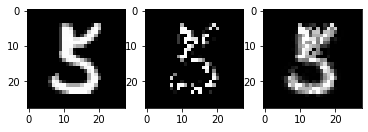

Original Image | Pixels Missing values | Imputed Image NO:  81


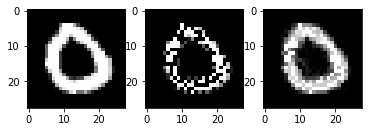

Original Image | Pixels Missing values | Imputed Image NO:  82


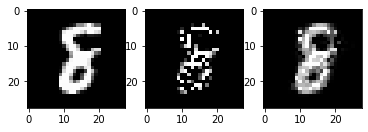

Original Image | Pixels Missing values | Imputed Image NO:  83


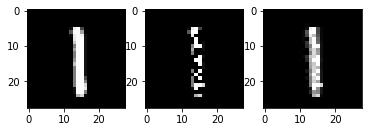

Original Image | Pixels Missing values | Imputed Image NO:  84


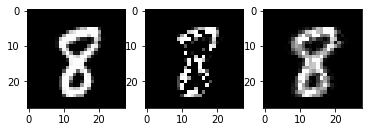

Original Image | Pixels Missing values | Imputed Image NO:  85


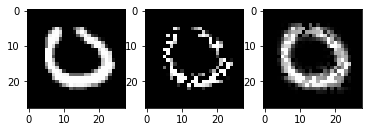

Original Image | Pixels Missing values | Imputed Image NO:  86


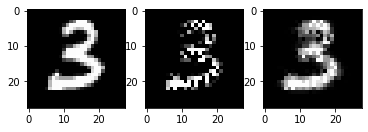

Original Image | Pixels Missing values | Imputed Image NO:  87


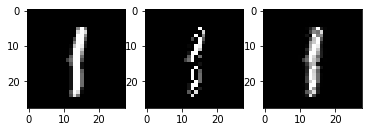

Original Image | Pixels Missing values | Imputed Image NO:  88


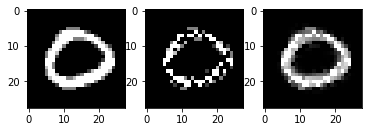

Original Image | Pixels Missing values | Imputed Image NO:  89


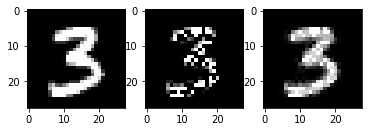

Original Image | Pixels Missing values | Imputed Image NO:  90


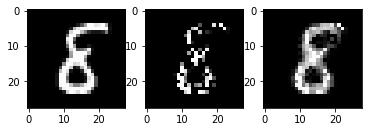

Original Image | Pixels Missing values | Imputed Image NO:  91


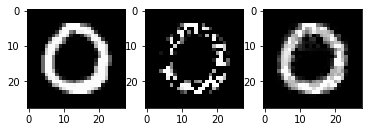

Original Image | Pixels Missing values | Imputed Image NO:  92


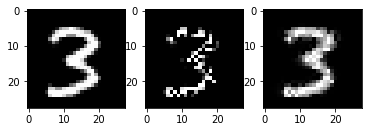

Original Image | Pixels Missing values | Imputed Image NO:  93


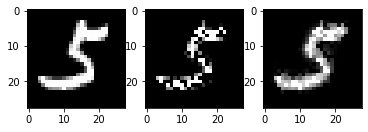

Original Image | Pixels Missing values | Imputed Image NO:  94


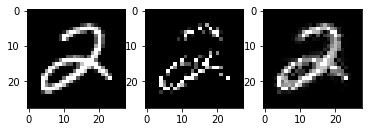

Original Image | Pixels Missing values | Imputed Image NO:  95


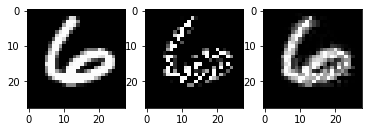

Original Image | Pixels Missing values | Imputed Image NO:  96


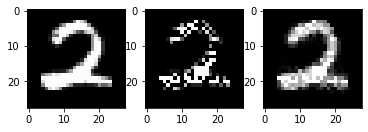

Original Image | Pixels Missing values | Imputed Image NO:  97


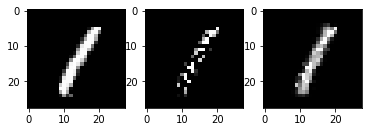

Original Image | Pixels Missing values | Imputed Image NO:  98


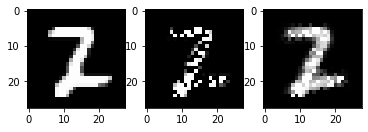

Original Image | Pixels Missing values | Imputed Image NO:  99


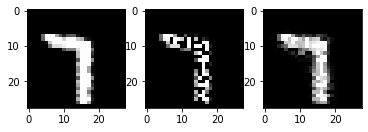

Original Image | Pixels Missing values | Imputed Image NO:  100


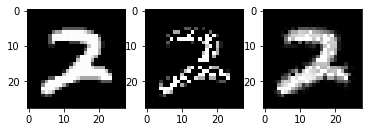

Original Image | Pixels Missing values | Imputed Image NO:  101


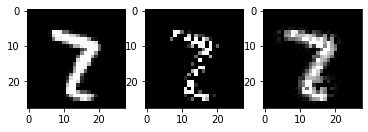

Original Image | Pixels Missing values | Imputed Image NO:  102


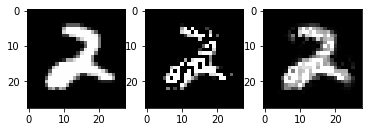

Original Image | Pixels Missing values | Imputed Image NO:  103


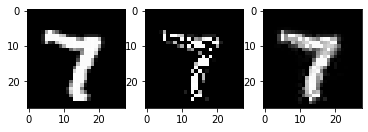

Original Image | Pixels Missing values | Imputed Image NO:  104


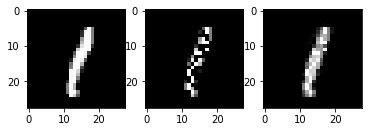

Original Image | Pixels Missing values | Imputed Image NO:  105


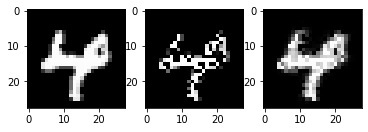

Original Image | Pixels Missing values | Imputed Image NO:  106


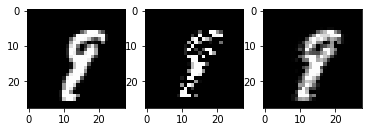

Original Image | Pixels Missing values | Imputed Image NO:  107


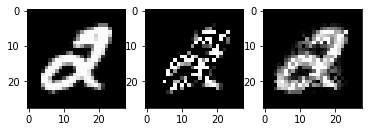

Original Image | Pixels Missing values | Imputed Image NO:  108


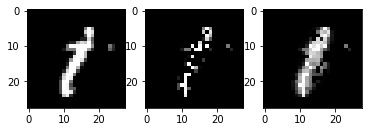

Original Image | Pixels Missing values | Imputed Image NO:  109


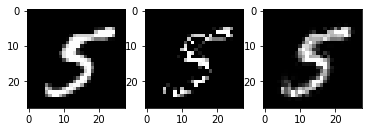

Original Image | Pixels Missing values | Imputed Image NO:  110


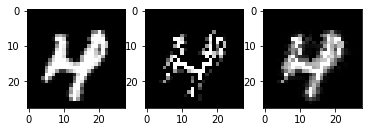

Original Image | Pixels Missing values | Imputed Image NO:  111


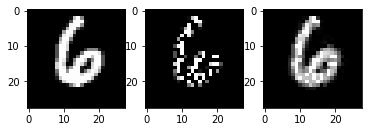

Original Image | Pixels Missing values | Imputed Image NO:  112


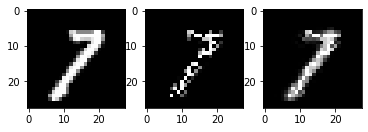

Original Image | Pixels Missing values | Imputed Image NO:  113


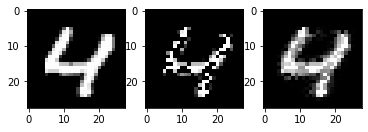

Original Image | Pixels Missing values | Imputed Image NO:  114


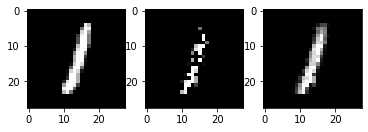

Original Image | Pixels Missing values | Imputed Image NO:  115


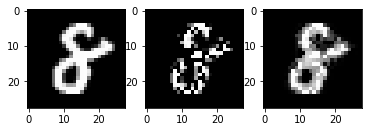

Original Image | Pixels Missing values | Imputed Image NO:  116


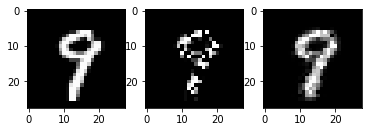

Original Image | Pixels Missing values | Imputed Image NO:  117


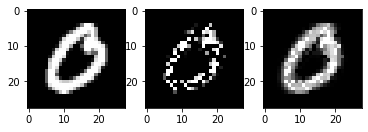

Original Image | Pixels Missing values | Imputed Image NO:  118


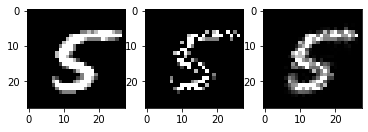

Original Image | Pixels Missing values | Imputed Image NO:  119


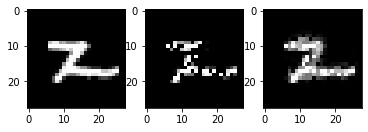

Original Image | Pixels Missing values | Imputed Image NO:  120


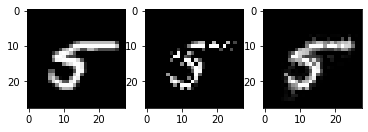

Original Image | Pixels Missing values | Imputed Image NO:  121


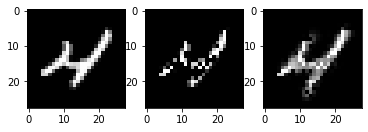

Original Image | Pixels Missing values | Imputed Image NO:  122


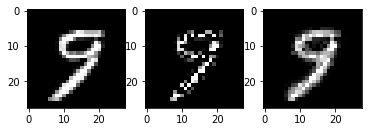

Original Image | Pixels Missing values | Imputed Image NO:  123


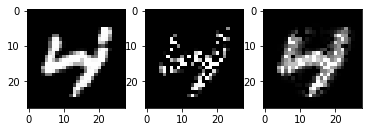

Original Image | Pixels Missing values | Imputed Image NO:  124


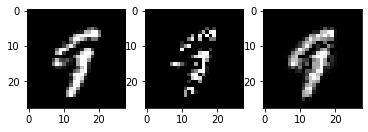

Original Image | Pixels Missing values | Imputed Image NO:  125


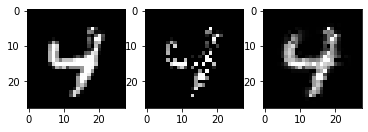

Original Image | Pixels Missing values | Imputed Image NO:  126


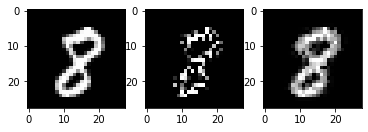

Original Image | Pixels Missing values | Imputed Image NO:  127


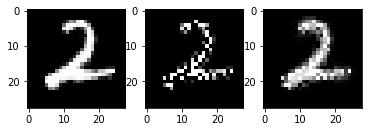

Original Image | Pixels Missing values | Imputed Image NO:  128


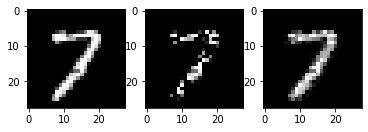

Original Image | Pixels Missing values | Imputed Image NO:  129


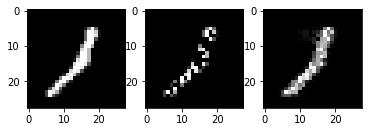

In [4]:
for number_chosen in range(1,130):
    
    f, axarr = plt.subplots(1,3)
    image_og = (inputs[0][number_chosen*5])
    img_og = image_og.view(28, 28).data
    mask, image_og_removed = removeProbDataTest(inputs[0][number_chosen*5],0.5)
    image_og_removed = image_og_removed.view(28, 28).data
    mask= mask.view(28, 28).data
    vae.float()
    image_imputed = vae.impute(inputs[0][number_chosen*5])
    image_imputed = image_imputed.view(28, 28).data
    image_final = image_imputed*mask + image_og_removed
    print('Original Image |','Pixels Missing values |', 'Imputed Image', 'NO: ',number_chosen)
    axarr[0].imshow(img_og,cmap='gray')
    axarr[1].imshow(image_og_removed,cmap='gray')
    axarr[2].imshow(image_final,cmap='gray')
    plt.show()

# Adding the Change to Loss Function as a novel Addition

In [5]:


# Building the encoder separately
class BasicBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BasicBlock, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.transform = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                       nn.Tanh(),
                                       nn.Linear(hidden_dim, hidden_dim),
                                       nn.Tanh())
        self.fc_mu = nn.Linear(hidden_dim, output_dim)
        self.fc_logsigma = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out = self.transform(x)
        mu = self.fc_mu(out)
        logsigma = self.fc_logsigma(out)
        sigma = torch.exp(logsigma)
        return mu, sigma
    
# Model
# Model
class MIWAE(nn.Module):
    def __init__(self, dim_h1, dim_image_vars):
        super(MIWAE, self).__init__()
        self.dim_h1 = dim_h1
        self.dim_image_vars = dim_image_vars

        ## encoder
        self.encoder_h1 = BasicBlock(dim_image_vars, 200, dim_h1)
        
        ## decoder
        self.decoder_x =  nn.Sequential(nn.Linear(dim_h1, 200),
                                        nn.Tanh(),
                                        nn.Linear(200, 200),
                                        nn.Tanh(),
                                        nn.Linear(200, dim_image_vars),
                                        nn.Sigmoid())
        
    def encoder(self, x):
        mu_h1, sigma_h1 = self.encoder_h1(x)
        eps = Variable(sigma_h1.data.new(sigma_h1.size()).normal_())
        h1 = mu_h1 + sigma_h1 * eps   
        return h1, mu_h1, sigma_h1, eps
    
    def decoder(self, h1):
        p = self.decoder_x(h1)

        return p
    
    def forward(self, x):
        h1, mu_h1, sigma_h1, eps = self.encoder(x)
        p = self.decoder(h1)
        return (h1, mu_h1, sigma_h1, eps), (p)

    def train_loss(self, inputs):
        h1, mu_h1, sigma_h1, eps = self.encoder(inputs)
        #log_Qh1Gx = torch.sum(-0.5*((h1-mu_h1)/sigma_h1)**2 - torch.log(sigma_h1), -1)
        log_Qh1Gx = torch.sum(-0.5*(eps)**2 - torch.log(sigma_h1), -1)
        
        loss_sigma = torch.sum(torch.log(sigma_h1), -1)
        loss_sigma_added = -torch.mean(torch.sum(loss_sigma, 0))
        print(loss_sigma_added)
        p = self.decoder(h1)
        log_Ph1 = torch.sum(-0.5*h1**2, -1)
        log_PxGh1 = torch.sum(inputs*torch.log(p) + (1-inputs)*torch.log(1-p), -1)

        log_weight = log_Ph1 + log_PxGh1 - log_Qh1Gx
        log_weight = log_weight - torch.max(log_weight, 0)[0]
        weight = torch.exp(log_weight)
        weight = weight / torch.sum(weight, 0)
        weight = Variable(weight.data, requires_grad = False)
        loss = -torch.mean(torch.sum(weight * (log_Ph1 + log_PxGh1 - log_Qh1Gx), 0))+loss_sigma_added*loss_sigma_added
        print('loss= ggg',loss)
        return loss

    
    def impute(self, inputs):
        inputs1 = inputs
        h1, mu_h1, sigma_h1, eps = self.encoder(inputs1)
        #log_Qh1Gx = torch.sum(-0.5*((h1-mu_h1)/sigma_h1)**2 - torch.log(sigma_h1), -1)
        log_Qh1Gx = torch.sum(-0.5*(eps)**2 - torch.log(sigma_h1), -1)
        
        p = self.decoder(h1)
        #print(p.shape)
        log_Ph1 = torch.sum(-0.5*h1**2, -1)
        log_PxGh1 = torch.sum(inputs1*torch.log(p) + (1-inputs1)*torch.log(1-p), -1)

        log_weight = log_Ph1 + log_PxGh1 - log_Qh1Gx
        log_weight = log_weight - torch.max(log_weight, 0)[0]
        
        weight = torch.exp(log_weight)
        weight = weight / torch.sum(weight, 0)
        #print(weight.shape)
        #weight = Variable(weight.data, requires_grad = False)
        weight.unsqueeze_(-1)
        weight = weight.expand(5,784)
        #print(weight.shape)
        img = torch.mean(weight * (p), 0)

        return img
    
vae = MIWAE(50, 784)
vae.double()

vae.load_state_dict(torch.load("miwae_with_changes.pt"))
vae.eval()


MIWAE(
  (encoder_h1): BasicBlock(
    (transform): Sequential(
      (0): Linear(in_features=784, out_features=200, bias=True)
      (1): Tanh()
      (2): Linear(in_features=200, out_features=200, bias=True)
      (3): Tanh()
    )
    (fc_mu): Linear(in_features=200, out_features=50, bias=True)
    (fc_logsigma): Linear(in_features=200, out_features=50, bias=True)
  )
  (decoder_x): Sequential(
    (0): Linear(in_features=50, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

# Testing Addition

Original Image | Pixels Missing values | Imputed Image NO:  1


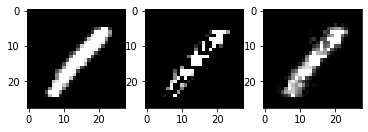

Original Image | Pixels Missing values | Imputed Image NO:  2


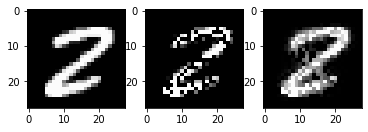

Original Image | Pixels Missing values | Imputed Image NO:  3


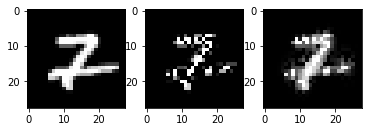

Original Image | Pixels Missing values | Imputed Image NO:  4


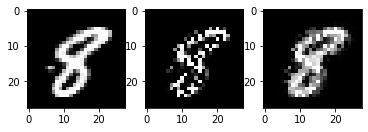

Original Image | Pixels Missing values | Imputed Image NO:  5


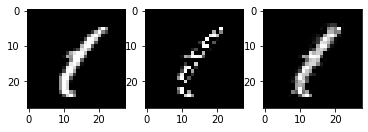

Original Image | Pixels Missing values | Imputed Image NO:  6


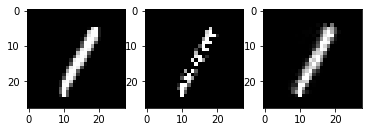

Original Image | Pixels Missing values | Imputed Image NO:  7


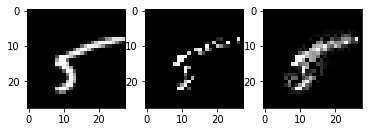

Original Image | Pixels Missing values | Imputed Image NO:  8


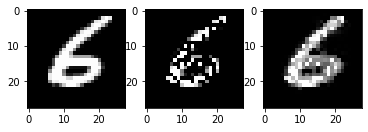

Original Image | Pixels Missing values | Imputed Image NO:  9


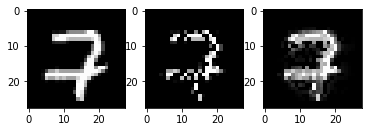

Original Image | Pixels Missing values | Imputed Image NO:  10


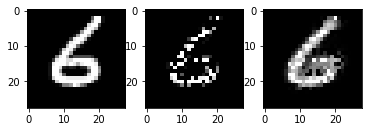

Original Image | Pixels Missing values | Imputed Image NO:  11


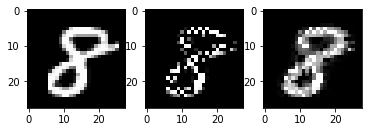

Original Image | Pixels Missing values | Imputed Image NO:  12


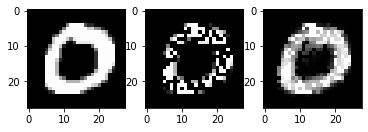

Original Image | Pixels Missing values | Imputed Image NO:  13


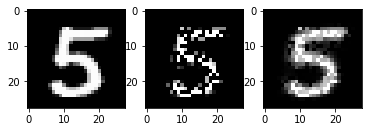

Original Image | Pixels Missing values | Imputed Image NO:  14


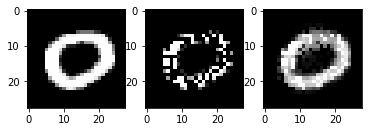

Original Image | Pixels Missing values | Imputed Image NO:  15


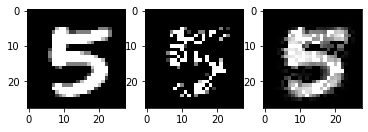

Original Image | Pixels Missing values | Imputed Image NO:  16


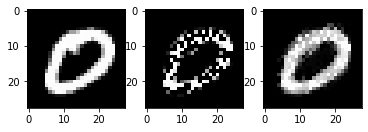

Original Image | Pixels Missing values | Imputed Image NO:  17


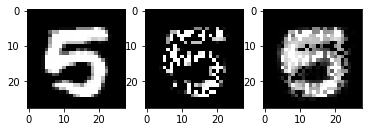

Original Image | Pixels Missing values | Imputed Image NO:  18


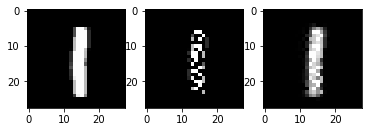

Original Image | Pixels Missing values | Imputed Image NO:  19


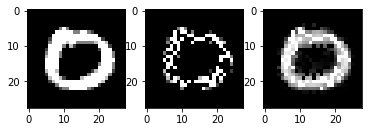

Original Image | Pixels Missing values | Imputed Image NO:  20


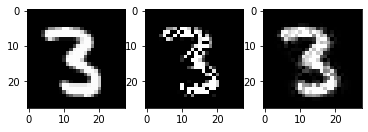

Original Image | Pixels Missing values | Imputed Image NO:  21


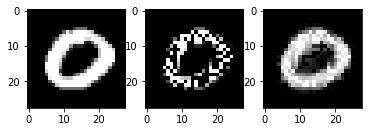

Original Image | Pixels Missing values | Imputed Image NO:  22


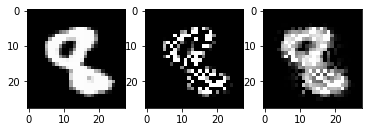

Original Image | Pixels Missing values | Imputed Image NO:  23


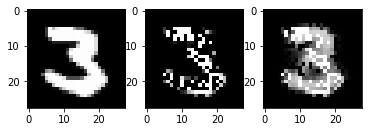

Original Image | Pixels Missing values | Imputed Image NO:  24


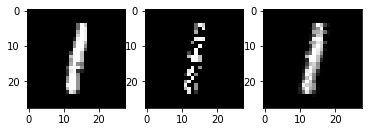

Original Image | Pixels Missing values | Imputed Image NO:  25


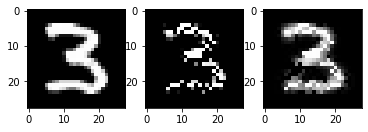

Original Image | Pixels Missing values | Imputed Image NO:  26


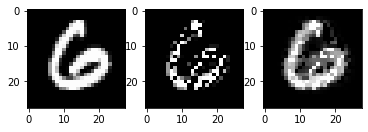

Original Image | Pixels Missing values | Imputed Image NO:  27


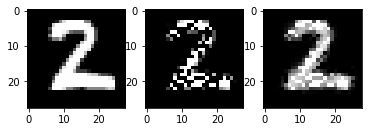

Original Image | Pixels Missing values | Imputed Image NO:  28


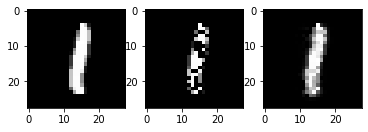

Original Image | Pixels Missing values | Imputed Image NO:  29


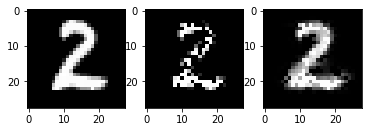

Original Image | Pixels Missing values | Imputed Image NO:  30


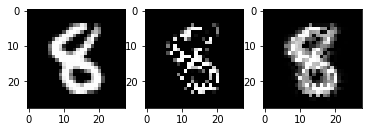

Original Image | Pixels Missing values | Imputed Image NO:  31


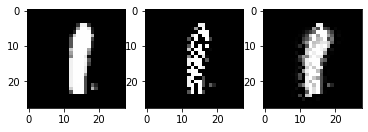

Original Image | Pixels Missing values | Imputed Image NO:  32


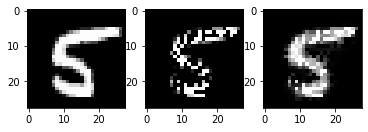

Original Image | Pixels Missing values | Imputed Image NO:  33


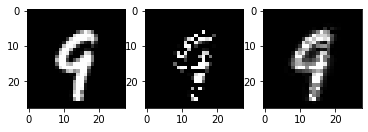

Original Image | Pixels Missing values | Imputed Image NO:  34


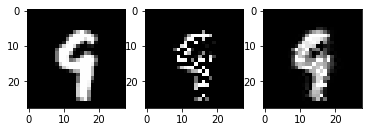

Original Image | Pixels Missing values | Imputed Image NO:  35


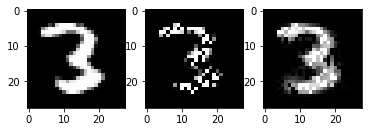

Original Image | Pixels Missing values | Imputed Image NO:  36


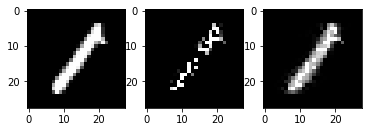

Original Image | Pixels Missing values | Imputed Image NO:  37


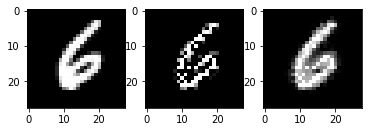

Original Image | Pixels Missing values | Imputed Image NO:  38


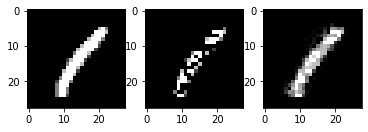

Original Image | Pixels Missing values | Imputed Image NO:  39


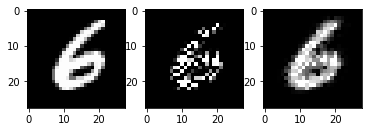

Original Image | Pixels Missing values | Imputed Image NO:  40


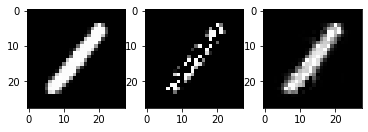

Original Image | Pixels Missing values | Imputed Image NO:  41


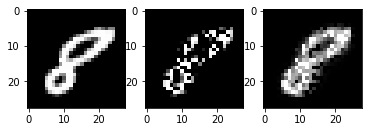

Original Image | Pixels Missing values | Imputed Image NO:  42


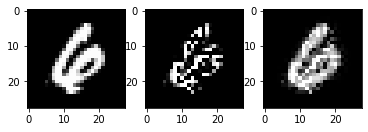

Original Image | Pixels Missing values | Imputed Image NO:  43


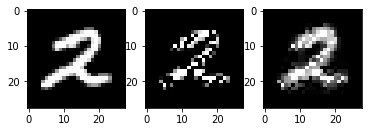

Original Image | Pixels Missing values | Imputed Image NO:  44


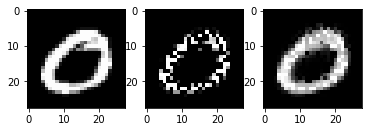

Original Image | Pixels Missing values | Imputed Image NO:  45


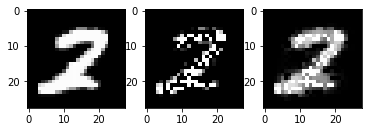

Original Image | Pixels Missing values | Imputed Image NO:  46


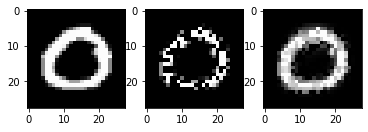

Original Image | Pixels Missing values | Imputed Image NO:  47


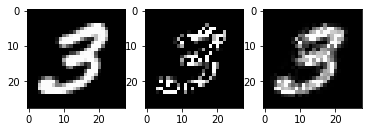

Original Image | Pixels Missing values | Imputed Image NO:  48


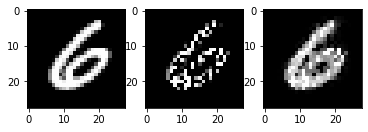

Original Image | Pixels Missing values | Imputed Image NO:  49


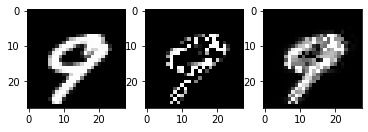

Original Image | Pixels Missing values | Imputed Image NO:  50


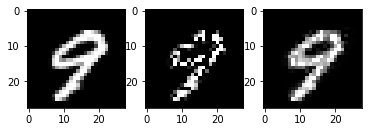

Original Image | Pixels Missing values | Imputed Image NO:  51


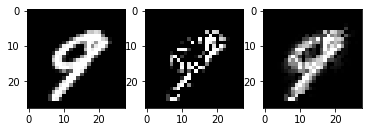

Original Image | Pixels Missing values | Imputed Image NO:  52


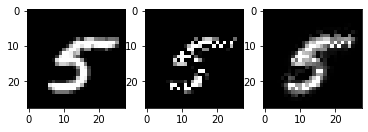

Original Image | Pixels Missing values | Imputed Image NO:  53


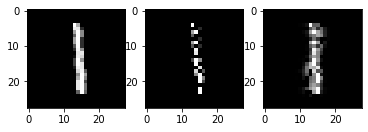

Original Image | Pixels Missing values | Imputed Image NO:  54


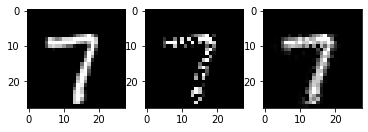

Original Image | Pixels Missing values | Imputed Image NO:  55


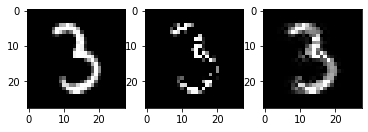

Original Image | Pixels Missing values | Imputed Image NO:  56


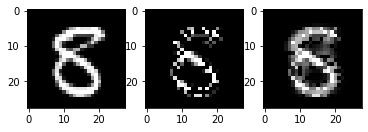

Original Image | Pixels Missing values | Imputed Image NO:  57


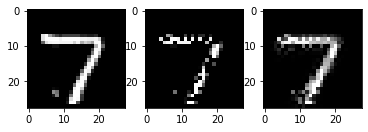

Original Image | Pixels Missing values | Imputed Image NO:  58


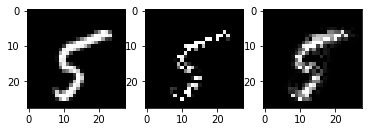

Original Image | Pixels Missing values | Imputed Image NO:  59


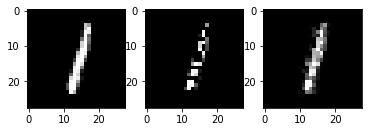

Original Image | Pixels Missing values | Imputed Image NO:  60


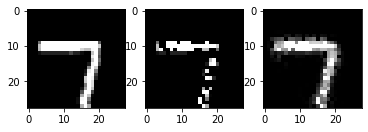

Original Image | Pixels Missing values | Imputed Image NO:  61


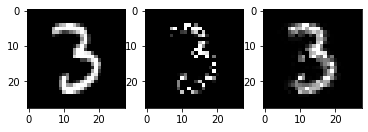

Original Image | Pixels Missing values | Imputed Image NO:  62


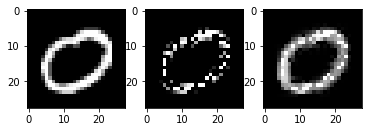

Original Image | Pixels Missing values | Imputed Image NO:  63


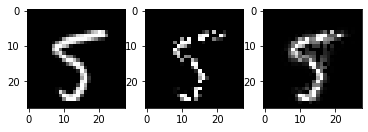

Original Image | Pixels Missing values | Imputed Image NO:  64


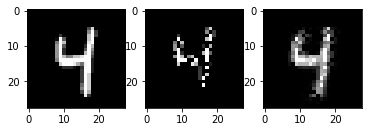

Original Image | Pixels Missing values | Imputed Image NO:  65


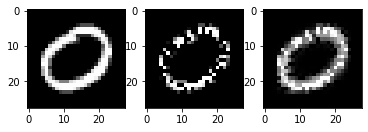

Original Image | Pixels Missing values | Imputed Image NO:  66


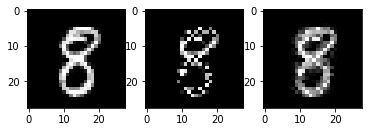

Original Image | Pixels Missing values | Imputed Image NO:  67


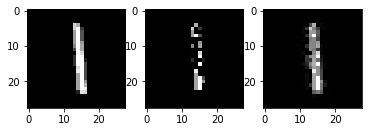

Original Image | Pixels Missing values | Imputed Image NO:  68


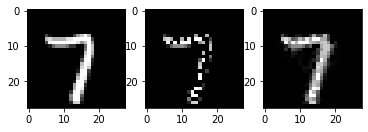

Original Image | Pixels Missing values | Imputed Image NO:  69


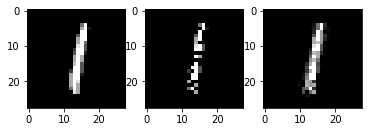

Original Image | Pixels Missing values | Imputed Image NO:  70


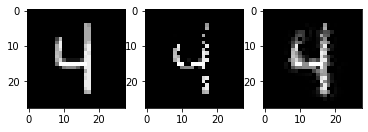

Original Image | Pixels Missing values | Imputed Image NO:  71


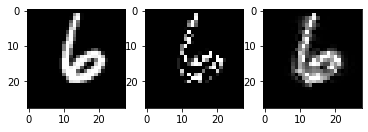

Original Image | Pixels Missing values | Imputed Image NO:  72


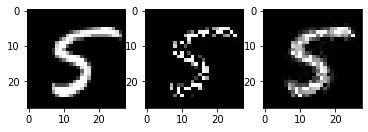

Original Image | Pixels Missing values | Imputed Image NO:  73


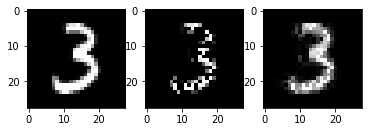

Original Image | Pixels Missing values | Imputed Image NO:  74


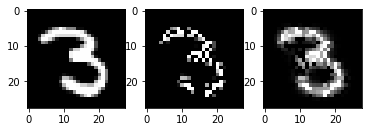

Original Image | Pixels Missing values | Imputed Image NO:  75


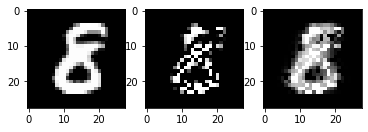

Original Image | Pixels Missing values | Imputed Image NO:  76


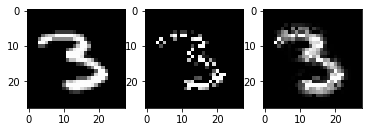

Original Image | Pixels Missing values | Imputed Image NO:  77


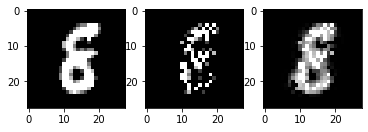

Original Image | Pixels Missing values | Imputed Image NO:  78


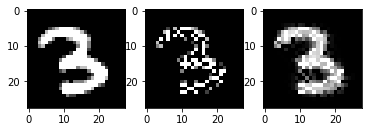

Original Image | Pixels Missing values | Imputed Image NO:  79


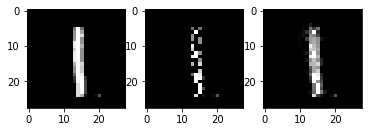

Original Image | Pixels Missing values | Imputed Image NO:  80


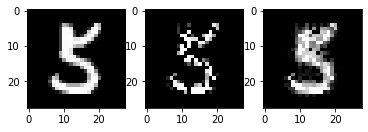

Original Image | Pixels Missing values | Imputed Image NO:  81


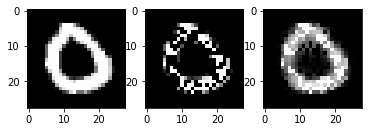

Original Image | Pixels Missing values | Imputed Image NO:  82


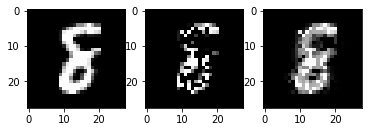

Original Image | Pixels Missing values | Imputed Image NO:  83


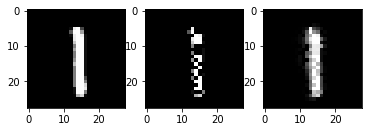

Original Image | Pixels Missing values | Imputed Image NO:  84


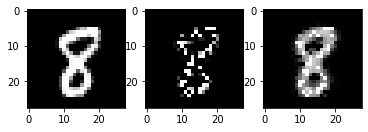

Original Image | Pixels Missing values | Imputed Image NO:  85


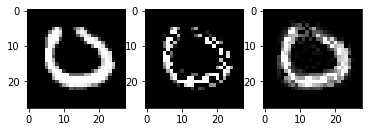

Original Image | Pixels Missing values | Imputed Image NO:  86


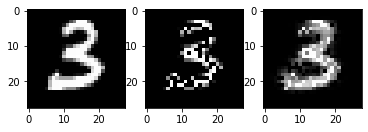

Original Image | Pixels Missing values | Imputed Image NO:  87


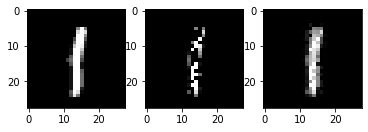

Original Image | Pixels Missing values | Imputed Image NO:  88


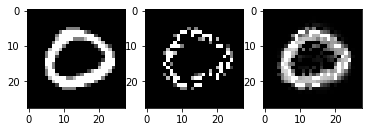

Original Image | Pixels Missing values | Imputed Image NO:  89


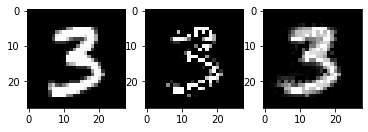

Original Image | Pixels Missing values | Imputed Image NO:  90


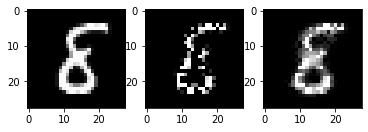

Original Image | Pixels Missing values | Imputed Image NO:  91


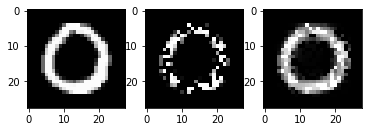

Original Image | Pixels Missing values | Imputed Image NO:  92


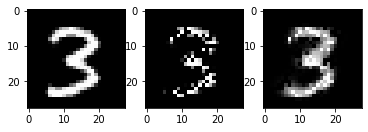

Original Image | Pixels Missing values | Imputed Image NO:  93


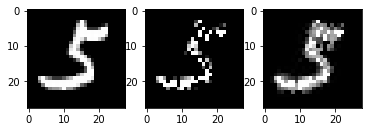

Original Image | Pixels Missing values | Imputed Image NO:  94


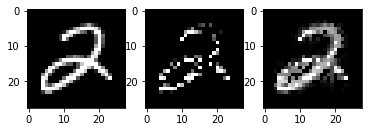

Original Image | Pixels Missing values | Imputed Image NO:  95


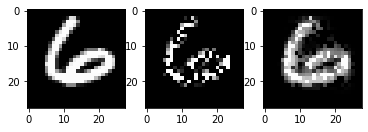

Original Image | Pixels Missing values | Imputed Image NO:  96


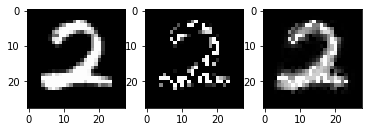

Original Image | Pixels Missing values | Imputed Image NO:  97


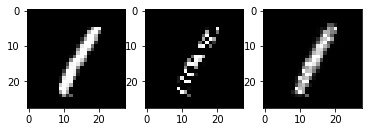

Original Image | Pixels Missing values | Imputed Image NO:  98


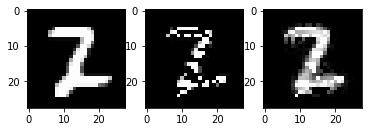

Original Image | Pixels Missing values | Imputed Image NO:  99


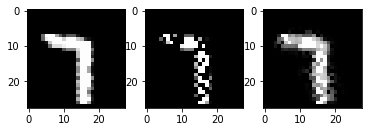

Original Image | Pixels Missing values | Imputed Image NO:  100


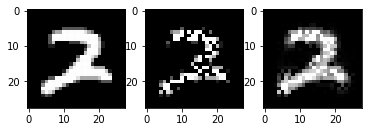

Original Image | Pixels Missing values | Imputed Image NO:  101


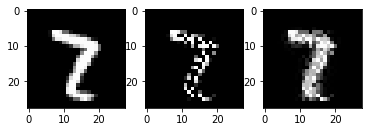

Original Image | Pixels Missing values | Imputed Image NO:  102


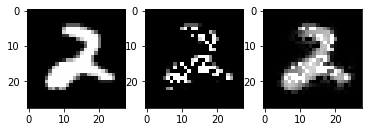

Original Image | Pixels Missing values | Imputed Image NO:  103


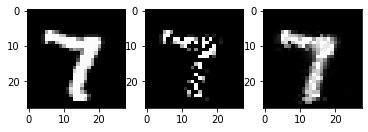

Original Image | Pixels Missing values | Imputed Image NO:  104


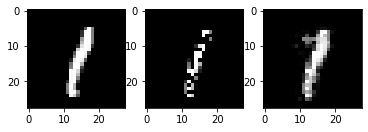

Original Image | Pixels Missing values | Imputed Image NO:  105


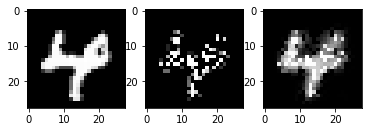

Original Image | Pixels Missing values | Imputed Image NO:  106


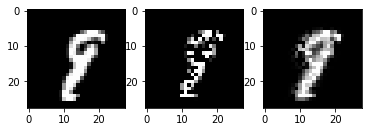

Original Image | Pixels Missing values | Imputed Image NO:  107


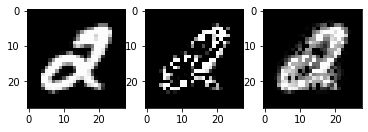

Original Image | Pixels Missing values | Imputed Image NO:  108


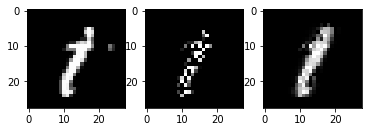

Original Image | Pixels Missing values | Imputed Image NO:  109


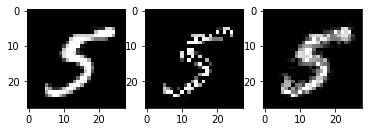

Original Image | Pixels Missing values | Imputed Image NO:  110


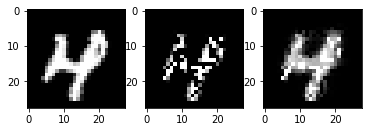

Original Image | Pixels Missing values | Imputed Image NO:  111


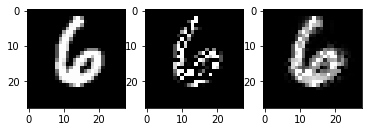

Original Image | Pixels Missing values | Imputed Image NO:  112


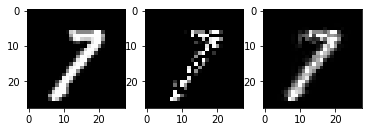

Original Image | Pixels Missing values | Imputed Image NO:  113


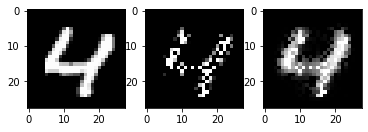

Original Image | Pixels Missing values | Imputed Image NO:  114


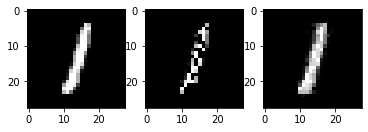

Original Image | Pixels Missing values | Imputed Image NO:  115


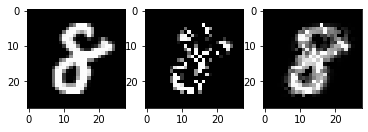

Original Image | Pixels Missing values | Imputed Image NO:  116


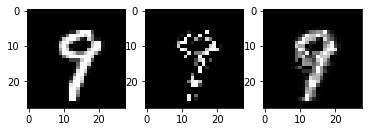

Original Image | Pixels Missing values | Imputed Image NO:  117


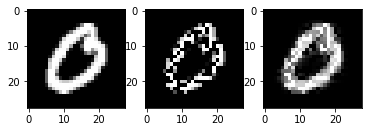

Original Image | Pixels Missing values | Imputed Image NO:  118


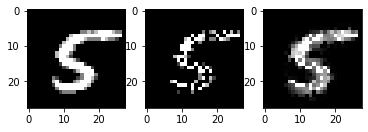

Original Image | Pixels Missing values | Imputed Image NO:  119


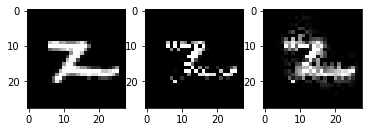

Original Image | Pixels Missing values | Imputed Image NO:  120


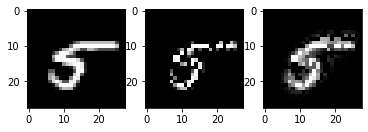

Original Image | Pixels Missing values | Imputed Image NO:  121


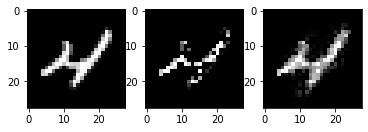

Original Image | Pixels Missing values | Imputed Image NO:  122


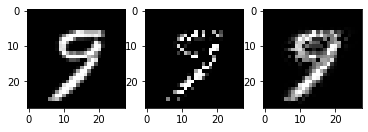

Original Image | Pixels Missing values | Imputed Image NO:  123


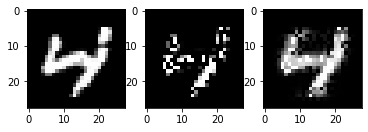

Original Image | Pixels Missing values | Imputed Image NO:  124


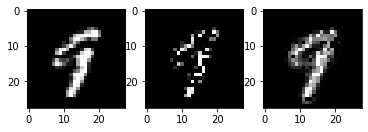

Original Image | Pixels Missing values | Imputed Image NO:  125


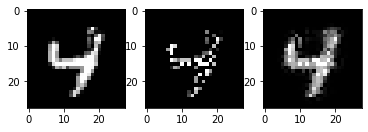

Original Image | Pixels Missing values | Imputed Image NO:  126


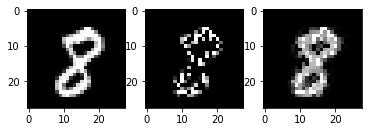

Original Image | Pixels Missing values | Imputed Image NO:  127


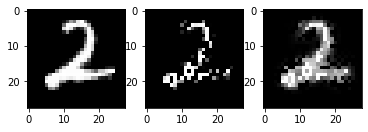

Original Image | Pixels Missing values | Imputed Image NO:  128


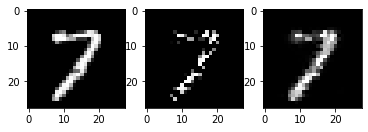

Original Image | Pixels Missing values | Imputed Image NO:  129


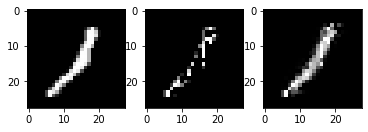

In [6]:
for number_chosen in range(1,130):
    
    f, axarr = plt.subplots(1,3)
    image_og = (inputs[0][number_chosen*5])
    img_og = image_og.view(28, 28).data
    mask, image_og_removed = removeProbDataTest(inputs[0][number_chosen*5],0.5)
    image_og_removed = image_og_removed.view(28, 28).data
    mask= mask.view(28, 28).data
    vae.float()
    image_imputed = vae.impute(inputs[0][number_chosen*5])
    image_imputed = image_imputed.view(28, 28).data
    image_final = image_imputed*mask + image_og_removed
    print('Original Image |','Pixels Missing values |', 'Imputed Image', 'NO: ',number_chosen)
    axarr[0].imshow(img_og,cmap='gray')
    axarr[1].imshow(image_og_removed,cmap='gray')
    axarr[2].imshow(image_final,cmap='gray')
    plt.show()